# Regularisation Methods: Ridge Regression

© Explore Data Science Academy

## Learning Objectives
In this train you will learn how to:

- Understand what regularisation is and how to implement it using the ridge method;
- Walk through the code required to implement a ridge regression model.

## Outline

This train is structured as follows:

- An introduction to regularisation;
- Review data scaling;
- Implement a ridge regression model;
- Compare performance of non-regularised linear model with regularised one.

## Regularisation in 5 minutes
Before we get started with the code in this train, let's go through the theory behind regularisation.   

When performing variable selection as we may have in previous trains, manual variable selection is often performed to improve the predictive accuracy of a model. The process of variable selection is discrete in that we either keep a variable, or we throw it away.   

Regularisation offers an alternative method in which all predictor variables are included, but are subject to constraint. Recall that the least squares method seeks to minimise the sum of the squares of the residuals:

$$RSS = \sum_{i=1}^n(y_i-\hat{y}_i)^2$$   

which can be written in terms of the predictor variable coefficients, [$b_1, b_2, b_p$], and slope, $a$:   

$$RSS = \sum_{i=1}^n(y_i-(a+\sum_{j=1}^pb_jx_{ij}))^2$$

where _n_ is the number of observations, and _p_ is the number of predictor variables. In the case of **ridge regression**, the regression coefficients are calculated as the values that minimise:

$$\sum_{i=1}^n(y_i-(a+\sum_{j=1}^pb_jx_{ij}))^2 + \alpha\sum_{j=1}^pb_j^2$$

which is rewritten simply as:

$$\min_{\beta} (RSS + \alpha\sum_{j=1}^pb_j^2)$$

In minimising _RSS_ , we improve the overall fit of the model. In the newly introduced term, $\alpha\sum_{j=1}^pb_j^2$, the intention is to penalise those individual coefficients that get too large (those that contribute the most to reducing the fit).

In the new term, $\alpha$ is a tuning parameter (which we calculate later on), which controls the degree to which the regression coefficients are penalised. The effect of this penalty parameter is to create a tradeoff between how much a coefficient contributes to minimising RSS and the size of the coefficient. In other words: _training fit_ vs. _size of coefficients_. 

In the newly introduced term, we can see that the penalty parameter is applied to the sum of the squares of the coefficients. This means that as we increase the size of the coefficients, the penalty will increase too. And so, this has the effect of _shrinking_ the coefficients towards zero.
 
![tradeoff](https://raw.githubusercontent.com/Explore-AI/Pictures/master/tradeoff.png)

## Getting started

To begin, let's import a few Python libraries.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Next we'll load our data as a Pandas DataFrame.

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Data/regression_sprint/regression_sprint_data_2.csv', index_col=0)
df.head()

,ZAR/USD,Value of Exports (USD),Value of Exports (ZAR),Value of Imports (USD),Value of Imports (ZAR),Total Reserves excl Gold (USD),IMF Reserve Position (USD),Foreign Exchange (USD),Claims on Non-residents (USD),Liabilities to Non-residents (USD),Central Bank Policy Rate,Money Market Rate,Treasury Bill Rate,Savings Rate,Deposit Rate,Lending Rate,Government Bonds,"Financial Market Prices, Equities Index",Producer Price Index,Consumer Price Index
2008M01,7.01,5611.90,39356.82,8105.11,56841.94,29884.51,1.92,29526.78,51547.61,37752.29,11.0,10.64,10.47,4.53,10.83,14.5,8.36,312.97,86.03,85.48
2008M02,7.66,6126.16,46946.33,8159.43,62527.78,30304.31,2.01,29943.04,59702.31,45927.67,11.0,10.66,10.32,5.61,11.00,14.5,8.69,335.09,87.23,85.91
2008M03,7.97,6417.48,51150.89,8010.87,63851.12,30615.42,2.05,30246.54,56448.18,42565.17,11.0,10.69,10.18,5.62,11.04,14.5,9.16,348.84,89.00,87.04
2008M04,7.79,7215.71,56174.34,9112.97,70944.49,30763.42,2.03,30399.21,55534.75,43342.70,11.5,11.00,10.27,5.80,11.28,15.0,9.15,358.47,90.83,87.61
2008M05,7.62,7379.67,56240.45,9090.14,69275.97,30831.43,2.10,30467.81,57682.89,46533.13,11.5,11.20,10.60,6.50,11.39,15.0,9.51,371.98,95.32,88.32


We can take a look at the dimensions of the dataframe to get an idea of the number of rows, _n_, and nummber of predictors, _p_, which is equal to one less than the number of columns.

In [3]:
df.shape

(120, 20)

We will be using a dataset which contains monthly data for the Rand/Dollar exchange rate, as well as a few potential predictor variables. In this case, the goal is to try and model the exchange rate, using the other 19 variables.   

The way we write this is as follows:   

$$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_pX_p$$   

In this case, $Y$ is the reponse variable which depends on the _p_ predictor variables.

### Review of Data Scaling

Data scaling is essential in regularisation as regularising penalizes a model for large coefficients. The magnitude of coefficients is dependent on the following:

* The strength of the relationship between the predictor variables (`x`) and the output variable (`y`)
* The units of measurement of x(eg. distance measured in millimetres or metres).For example, if x is measured in metres, and its coefficient is 5; if it is expressed in kilometres, its coefficient will be 5*10³.

We want regularisation to be impacted by the strength of the relationship that exists between `x` and `y` variables and not the latter case. Thus, to eliminate the impact of the units of measurement of the variables on the coefficients, data scaling is performed to ensure variables are fairly scaled. **Z-score standardisation** is a great way to scale variables such that they have similar (though not identical) ranges, in a way that is fairly robust to outlier values. Let's go ahead an apply standard scaling to our model. 

We'll import the `StandardScalar()` object from `sklearn.preprocessing`.

In [4]:
# Split data into predictors and response
X = df.drop('ZAR/USD', axis=1)
y = df['ZAR/USD']

In [5]:
# Import scaler method from sklearn
from sklearn.preprocessing import StandardScaler

In [6]:
# Create scaler object
scaler = StandardScaler()

In [7]:
# Create scaled version of the predictors (there is no need to scale the response)
X_scaled = scaler.fit_transform(X)

In [8]:
# Convert the scaled predictor values into a dataframe
X_standardise = pd.DataFrame(X_scaled,columns=X.columns)
X_standardise.head()

,Value of Exports (USD),Value of Exports (ZAR),Value of Imports (USD),Value of Imports (ZAR),Total Reserves excl Gold (USD),IMF Reserve Position (USD),Foreign Exchange (USD),Claims on Non-residents (USD),Liabilities to Non-residents (USD),Central Bank Policy Rate,Money Market Rate,Treasury Bill Rate,Savings Rate,Deposit Rate,Lending Rate,Government Bonds,"Financial Market Prices, Equities Index",Producer Price Index,Consumer Price Index
0,-1.341230,-1.820002,0.205077,-1.124305,-2.145276,-0.740237,-2.040128,0.325086,-0.356166,2.195535,2.098427,2.225653,0.692028,2.036107,2.195535,-0.234691,2.625151,-1.613707,-1.690995
1,-0.934909,-1.404295,0.248319,-0.821735,-2.057421,-0.739864,-1.936778,2.106157,1.670410,2.195535,2.108767,2.136289,1.529205,2.124739,2.195535,0.294266,2.985518,-1.567326,-1.667091
2,-0.704734,-1.173995,0.130057,-0.751314,-1.992313,-0.739698,-1.861424,1.395422,0.836888,2.195535,2.124275,2.052883,1.536956,2.145593,2.195535,1.047628,3.209525,-1.498915,-1.604276
3,-0.074046,-0.898842,1.007391,-0.373843,-1.961339,-0.739781,-1.823519,1.195919,1.029628,2.452574,2.284533,2.106501,1.676486,2.270721,2.452574,1.031600,3.366412,-1.428184,-1.572591
4,0.055500,-0.895220,0.989217,-0.462633,-1.947106,-0.739490,-1.806486,1.665095,1.820496,2.452574,2.387925,2.303101,2.219101,2.328071,2.452574,1.608643,3.586510,-1.254644,-1.533123


## Ridge Regression
We will first split our data into a training and a testing set. We'll use the first eight years of data as our training set and test the model on the final two years. Note that with time-series data it isn't appropriate to sample rows randomly for the training and testing sets because chronological order remains important.

Since we are done splitting our dataset, we can go ahead and fit and test our model. For now, we are going to create a `Ridge()` object without modifying any of the parameters. This means that we will use the default value of $\alpha=1$. In a later tutorial, we'll learn about choosing a better value for this hyperparameter.

In [9]:
# Import train/test splitting function from sklearn
from sklearn.model_selection import train_test_split

In [24]:
# Split the data into train and test, being sure to use the standardised predictors
X_train, X_test, y_train, y_test = train_test_split(X_standardise, 
                                                    y, 
                                                    test_size=0.2, 
                                                    shuffle=False)

In [11]:
# Import the ridge regression module from sklearn
from sklearn.linear_model import Ridge

In [12]:
# Create ridge model
ridge = Ridge()

In [13]:
# Train the model
ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [14]:
# Extract the model intercept value
b0 = float(ridge.intercept_)

In [15]:
# Extract the model coefficient value
coeff = pd.DataFrame(ridge.coef_, X.columns, columns=['Coefficient'])

In [16]:
print("Intercept:", float(b0))

Intercept: 10.126890070063201


In [17]:
# Check out the coefficients
coeff

,Coefficient
Value of Exports (USD),-0.542478
Value of Exports (ZAR),0.973215
Value of Imports (USD),-0.711990
Value of Imports (ZAR),0.957165
Total Reserves excl Gold (USD),0.012201
IMF Reserve Position (USD),0.036197
Foreign Exchange (USD),0.120280
Claims on Non-residents (USD),0.069619
Liabilities to Non-residents (USD),0.003063
Central Bank Policy Rate,0.189549


### Interpretation of the intercept and coefficients

Because we standardised the features, we can compare coefficients to each other, since their respective variables are all on the same scale. We can interpret the intercepts as the expected exchange rate when all the features are equal to their respective means and the coefficients are interpreted as the expected change in exchange rate given an increase of 1 in the **scaled feature value**. 

We can intepret variables with smaller coefficients as less important as they have suffered more in the shrinkage tradeoff.

## Assess the predictive accuracy of the  model 
We can make use of the `sklearn.metrics` library to assess the accuracy of our model. For comparison, we'll fit a linear model (without regularisation) to the data.

In [18]:
# Fit a basic linear model
from sklearn.linear_model import LinearRegression

# Create model object
lm = LinearRegression()

# Train model
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
# Import metrics module
from sklearn import metrics

In [20]:
# Check training accuracy
train_lm = lm.predict(X_train)
train_ridge = ridge.predict(X_train)

print('Training MSE')
print('Linear:', metrics.mean_squared_error(y_train, train_lm))
print('Ridge :', metrics.mean_squared_error(y_train, train_ridge))

Training MSE
Linear: 0.03265357021356955
Ridge : 0.03969613809819073


In [21]:
test_lm = lm.predict(X_test)
test_ridge = ridge.predict(X_test)

print('Testing MSE')
print('Linear:', metrics.mean_squared_error(y_test, test_lm))
print('Ridge :', metrics.mean_squared_error(y_test, test_ridge))

Testing MSE
Linear: 1.6836012098828128
Ridge : 0.6691856898179852


We can see that Ridge regression achieves a much lower score on the testing set at the expense of a slightly higher score on the training set. The increase in training MSE is not anything to be worried about since we want to avoid overfitting on the training set.   

As a final step, let's plot our results.

In [22]:
# We want to plot the train and test response variables as a continuous line
train_plot = y_train.append(pd.Series(y_test[0], index=['2016M01']))

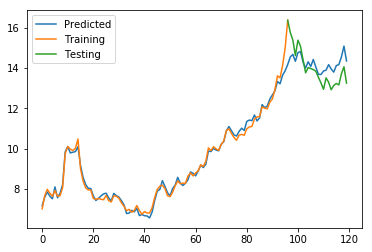

In [25]:
plt.plot(np.arange(len(y)), ridge.predict(X_standardise), label='Predicted')
plt.plot(np.arange(len(train_plot)), train_plot, label='Training')
plt.plot(np.arange(len(y_test))+len(y_train), y_test, label='Testing')
plt.legend()

plt.show()

## Conclusion

In this train we have seen or been introduced to:

- The concept of regularisation in general and ridge regularisation in particular;
- Implementing a linear model using ridge regularisation;
- Comparing the accuracy of a non-regularised linear regression model with a regularised one.

## Appendix

Links to additional resources to help with the understanding of concepts presented in the train.

- [Video on ridge regression by the authors of ISLR](https://www.youtube.com/watch?v=cSKzqb0EKS0)